In [3]:
import os
from dotenv import find_dotenv, load_dotenv
_ = load_dotenv(find_dotenv())
import json
from utils import json_load, json_dump, mkdir

In [4]:
K = 10
SOURCE_DIR = os.path.join('data', 'deliverables')
exam_dataset_file_path = os.path.join(SOURCE_DIR, 'gemma_response_with_tavily.json')
exam_data = json_load(exam_dataset_file_path)
exam_data[0]

load data from: data/deliverables/gemma_response_with_tavily.json


{'query': '題目: 常見針灸配穴法中,所指的「四關穴」,為下列何穴位之組合?\n選項:\n A: 上星、日月\n B: 合谷、太衝\n C: 內關、外關\n D: 上關、下關\n',
 'reference_answer': 'B',
 'response': {'ans': 'C',
  'feedback': '題目問的是「四關穴」，而參考資料中沒有提及四關穴的定義或組成。因此，無法根據提供的資料判斷正確答案。'},
 'wiki_results': {'四關穴': None,
  '合谷': {'title': '合谷穴',
   'url': 'https://zh.wikipedia.org/wiki/%E5%90%88%E8%B0%B7%E7%A9%B4',
   'summary': '合谷穴（LI 4）是手陽明大腸經的原穴，出自《靈樞·本輸》，又名虎口。“合”意即合攏，“谷”是山谷的意思。此穴在第一、二掌骨之間，兩骨相合，形狀如山谷的地方，所以名為合谷。又因位於手拇指虎口兩骨之間，所以又稱為虎口。',
   'content': '合谷穴（LI 4）是手陽明大腸經的原穴，出自《靈樞·本輸》，又名虎口。“合”意即合攏，“谷”是山谷的意思。此穴在第一、二掌骨之間，兩骨相合，形狀如山谷的地方，所以名為合谷。又因位於手拇指虎口兩骨之間，所以又稱為虎口。\n\n\n== 定位 ==\n位於手背，第一、二掌骨之間，約當第二掌骨橈側的中點處取穴。\n\n\n== 取穴法 ==\n簡便取穴法：以一手的拇指指骨關節橫紋，放在另一手拇、食指之間的指蹼緣上，當拇指尖下是穴。\n\n《針灸甲乙經》：在手大指次指歧骨間。\n《針灸大成》：在手大指次指歧骨間陷中。\n\n\n== 局部解剖 ==\n在第一、二掌骨之間，第一骨間背側肌中，深層有拇內收肌橫頭。有手背靜脈網。腧穴近側正當橈動脈從手背穿向手掌之處。布有橈神經淺支的掌背側神經，深部有正中神經的指掌側固有神經。\n\n\n== 刺灸法 ==\n直刺0.5-0.8寸，可灸。\n\n《針灸大成》：針三分, 留六呼, 灸三壯。合谷，婦人妊娠可瀉不可補，補即墮胎。\n\n\n== 主治 ==\n功能：清熱解表，明目聰耳，鎮靜止痛\n主治：\n\n本經脈所過部位的疾患：指孿，臂痛，半身不遂。\n外感疾患：熱病無汗，多汗，咳

In [5]:
from llama_index.llms.openai import OpenAI
from llama_index.core.evaluation import FaithfulnessEvaluator
from llama_index.core.evaluation import ContextRelevancyEvaluator
llm = OpenAI(model="gpt-5-mini", temperature=0, is_streaming=False)
faithful = FaithfulnessEvaluator(llm=llm)
context_relevancy = ContextRelevancyEvaluator(llm)

In [6]:
rvs = []
for idx, qset in enumerate(exam_data):
    print(idx, end=', ')
    rv = qset.copy()
    query = qset['query']
    response = f"ans: {qset['response_v2']['ans']}\nfeedback: {qset['response_v2']['feedback']}"
    context = qset['context_v2']
    cr_result = context_relevancy.evaluate(query=query, contexts=[context])
    rv['cr_feedback'] = cr_result.feedback
    rv['cr_score'] = cr_result.score

    ff_result = faithful.evaluate(response=response, contexts=[context])
    rv['ff_feedback'] = ff_result.feedback
    rv['ff_score'] = ff_result.score
    rvs.append(rv)

/home/poyuan/miniconda3/envs/rag30/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
DEST_DIR = os.path.join('data', 'deliverables')
save_file_path = os.path.join(DEST_DIR, 'gemma_response_with_tavily_proxy.json')
json_dump(save_file_path, rvs)

dump result to: data/deliverables/gemma_response_with_tavily_proxy.json


In [11]:
correct_ff = []
incorrect_ff = []
correct_cr = []
incorrect_cr = []
correct_idx = []
incorrect_idx = []

for idx, data in enumerate(rvs):
    
    ans = data['reference_answer']
    pred = data['response_v2']['ans']
    print(ans, pred)
    if ans == pred:
        correct_idx.append(idx)
        correct_ff.append(data['ff_score'])
        correct_cr.append(data['cr_score'])
    else:
        incorrect_idx.append(idx)
        incorrect_ff.append(data['ff_score'])
        incorrect_cr.append(data['cr_score'])

len(correct_ff), len(incorrect_ff)

B B
A A
A A
D C
B A
C C
C A
B B
A A
C C


(7, 3)

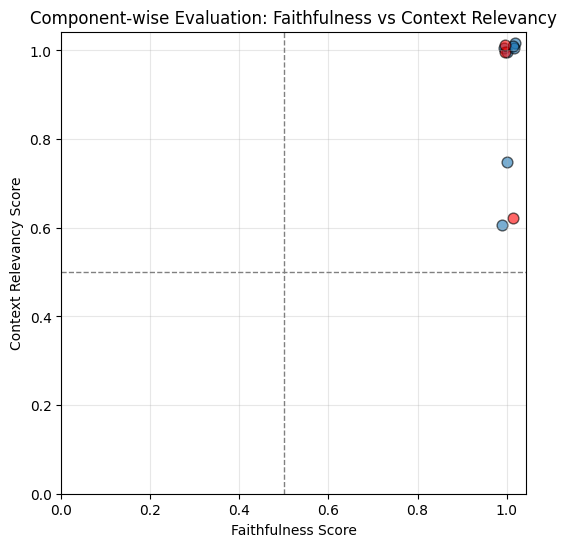

In [12]:
import numpy as np
import matplotlib.pyplot as plt

faithful_score = correct_ff
context_score = correct_cr

# 加上小擾動 (jitter)，避免點完全重疊
jitter_strength = 0.02  # 可以依需求調整
x = faithful_score + np.random.uniform(-jitter_strength, jitter_strength, size=len(faithful_score))
y = context_score + np.random.uniform(-jitter_strength, jitter_strength, size=len(context_score))

plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.6, s=60, edgecolor='k')

# 畫 threshold 線 (例如 0.5)
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
plt.axvline(0.5, color='gray', linestyle='--', linewidth=1)

plt.xlabel("Faithfulness Score")
plt.ylabel("Context Relevancy Score")
plt.title("Component-wise Evaluation: Faithfulness vs Context Relevancy")
plt.grid(alpha=0.3)


faithful_score = incorrect_ff
context_score = incorrect_cr
# 加上小擾動 (jitter)，避免點完全重疊
jitter_strength = 0.02  # 可以依需求調整
x = faithful_score + np.random.uniform(-jitter_strength, jitter_strength, size=len(faithful_score))
y = context_score + np.random.uniform(-jitter_strength, jitter_strength, size=len(context_score))
plt.scatter(x, y, alpha=0.6, s=60, edgecolor='k', color='r')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()
